## Project description.

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.

One of the most common problems gyms and other services face is customer churn. How do we know if a customer is no longer with us? We can calculate churn based on people who get rid of their accounts or don't renew their contracts. However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.

Churn indicators vary from field to field. If a user buys from an online store rarely but regularly, we can't say they're a runaway. But if for two weeks they haven't opened a channel that's updated daily, that's a reason to worry: your follower might have gotten bored and left you.

For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. My task in this project is to analyze them and come up with a customer retention strategy.

I'm going to:
 - Learn to predict the probability of churn (for the upcoming month) for each customer
 - Draw up typical user portraits: select the most outstanding groups and describe their main features
 - Analyze the factors that impact churn most
 - Draw basic conclusions and develop recommendations on how to improve customer service

#### The process would include the following steps:

**[Step 1. Downloading the data and preparing it for analysis](#Step-1.-Downloading-the-data-and-preparing-it-for-analysis)**  <br>

**[Step 2. Exploratory data analysis (EDA)](#Step-2.-Exploratory-data-analysis-(EDA))**

**[Step 3. Building a model to predict user churn](#Step-3.-Building-a-model-to-predict-user-churn)**

**[Step 4. Creating user clusters](#Step-4.-Creating-user-clusters)**

**[Step 5. Overall conclusion](#Step-5.-Overall-conclusion)**

## Step 1. Downloading the data and preparing it for analysis

#### Description of the data:

Model Fitness provided us with CSV file containing data on churn for a given month and information on the month preceding it. <br> 
The dataset includes the following fields:

 - `Churn` — the fact of churn for the month in question
 - `gender`
 - `Near_Location` — whether the user lives or works in the neighborhood where the gym is located
 - `Partner` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
 - `Promo_friends` — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
 - `Phone` — whether the user provided their phone number
 - `Age`
 - `Lifetime` — the time (in months) since the customer first came to the gym
 - `Contract_period` — 1 month, 3 months, 6 months, or 1 year
 - `Month_to_end_contract` — the months remaining until the contract expires
 - `Group_visits` — whether the user takes part in group sessions
 - `Avg_class_frequency_total` — average frequency of visits per week over the customer's lifetime
 - `Avg_class_frequency_current_month` — average frequency of visits per week over the preceding month
 - `Avg_additional_charges_total` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

Let's import and open our dataset:

In [1]:
!pip install seaborn --upgrade -q

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

df = pd.read_csv("gym_churn_us.csv")

df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
606,0,1,0,0,1,1,0,23,108.919001,1.0,2,1.250559,0.144225,1
3170,0,1,0,0,1,1,1,26,172.221079,1.0,8,0.000000,0.012825,0
3481,0,1,0,0,1,1,1,30,44.419101,1.0,0,1.692924,1.613738,0
1977,0,1,1,1,1,12,1,33,271.639795,12.0,1,3.466005,3.341119,0
671,1,1,0,0,0,1,0,32,166.153122,1.0,0,1.034316,0.492118,1
3210,1,1,0,0,1,1,0,26,42.631635,1.0,1,1.757168,1.439634,1
870,0,1,0,0,1,1,1,32,67.587775,1.0,4,1.216622,1.333863,0
1004,0,1,0,0,1,1,0,28,108.925748,1.0,0,1.757286,2.094565,1
1346,0,1,0,0,1,1,0,30,187.762024,1.0,8,1.866457,1.881198,0
2123,0,1,1,0,1,1,1,28,47.454051,1.0,2,0.752629,0.660481,1


We have data for 4000 customers, there're no missing values in the dataset. Let's lowercase column names:

In [2]:
df.columns = df.columns.str.lower()

Column data types seem to be correct everywhere except for `month_to_end_contract` column which we might want to convert to integer data type:

In [3]:
df.month_to_end_contract.unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

As we can see, there are only integer values in this column.

In [4]:
df.month_to_end_contract = df.month_to_end_contract.astype('int')

## Step 2. Exploratory data analysis (EDA)

Let's take a look at mean values and standard deviations of all customers' parameters:

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


That doesn't look like any feature has any serious outliers. <br>
Now let's split customers in 2 groups: those who left (churn) and for those who stayed, and compare mean feature values for those groups.

In [6]:
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


From the table above we can say that on average:
 - customers who left don't **live** as **close** to the gym as the ones who stayed
 - participants of **partner program** are more likely to stay, as well as customers who signed up through **friends**
 - customers who left had **shorter contract periods**
 - those who are taking part in **group sessions** are more likely to stay
 - users who left are slightly **younger** than those who stayed
 - loyal customers who didn't leave spend more money on various **gym services**
 - the less time left to the **end of the contract** - the more likely for customer to leave the gym
 - people usually leave around the end of the **first month** since the first time they came to the gym
 - customers who have higher frequency of visits per week (**classes**) are more likely to stay
 - **gender** and whether or not the user provided their **phone number** have no impact on churn
 
Let's plot bar histograms and feature distributions to illustrate these conclusions that we came up with:    

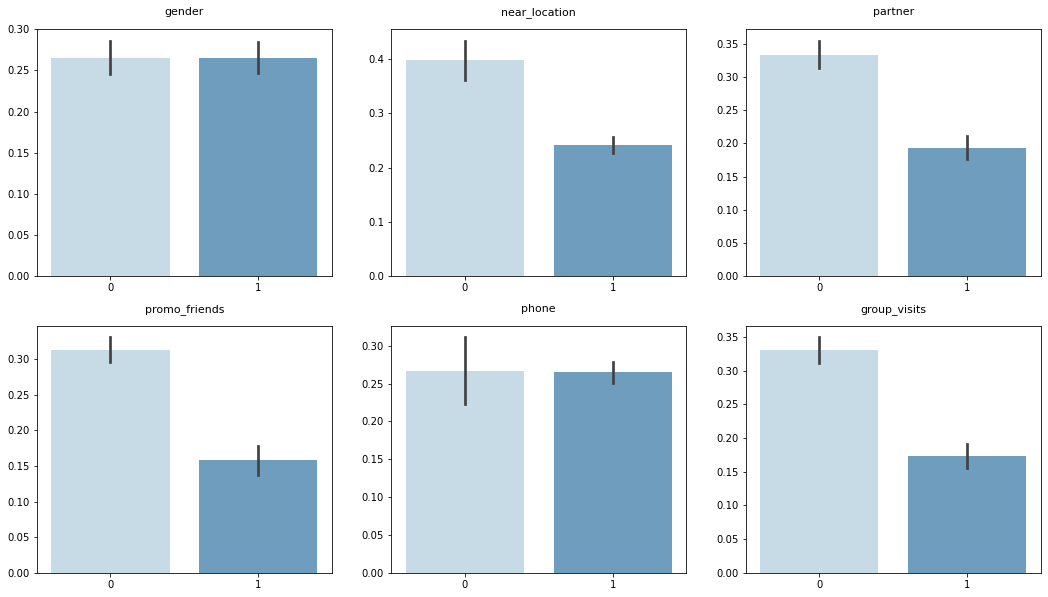

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

i=0

for col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    sns.barplot(ax=axes[i//3, i%3], x=df[col], y=df['churn'], palette="Paired", alpha=0.7)
    axes[i//3, i%3].set_title(col, fontdict ={'size':11}, pad=14)
    i+=1

plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='')
plt.show()  

Again, we can see:
 - **gender, phone** - no impact on churn
 - those customers who **live close**, are participants of **partner** program, signed up through **friends** or attend **group visits** are less likely to left

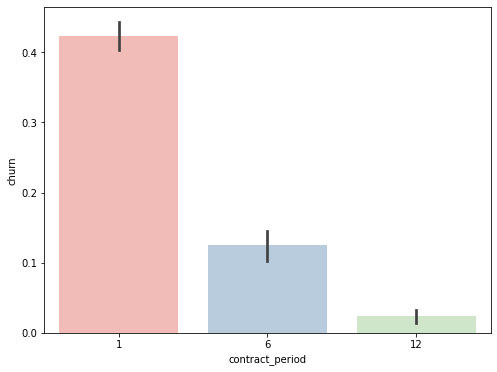

In [8]:
fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=df['contract_period'], y=df['churn'], palette="Pastel1")
plt.show()

The shorter **contaract period** - the more chance that customer will stop using service.

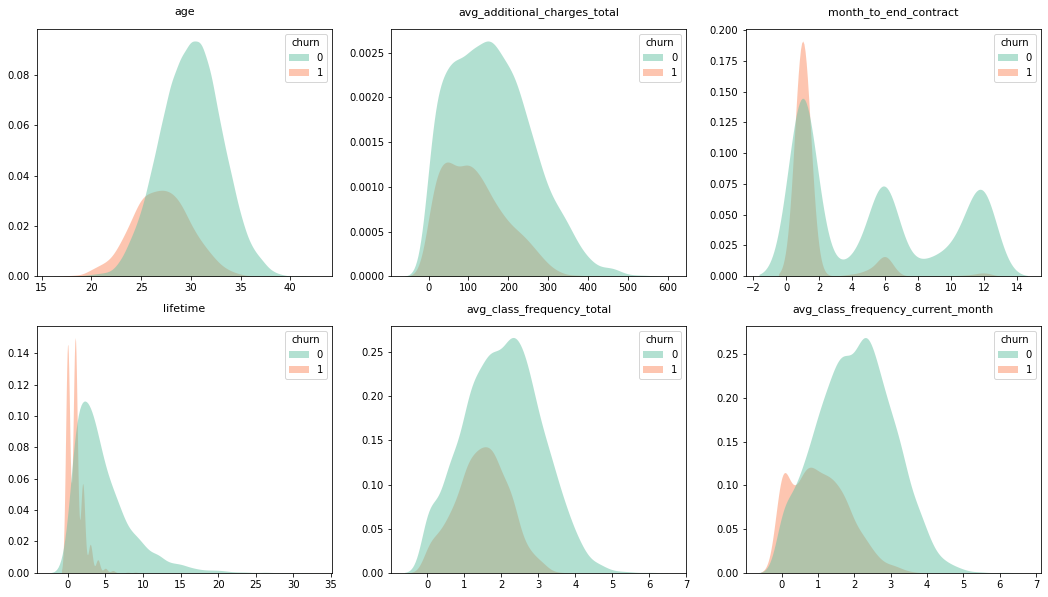

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

i=0

for col in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    sns.kdeplot(ax=axes[i//3, i%3], data=df, x=col, hue='churn', fill=True, palette="Set2", alpha=0.5, linewidth=0)
    axes[i//3, i%3].set_title(col, fontdict ={'size':11}, pad=14)
    i+=1

plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='')
plt.show()    

 - older people are more likely to stay (churn happens mostly among 20-35 age group)
 - customers who spend a lot of money on gym services or attend more classes are more likely to stay
 - people leave within first 5 months of the contract (most likely they will leave within first two months)
 - also that's very likely to leave for someone who has one month left till the end of contract, or, more rarely, 6 months till the end
 
Let's build a correlation matrix to see if there're any correlations between features and display it as a heatmap:

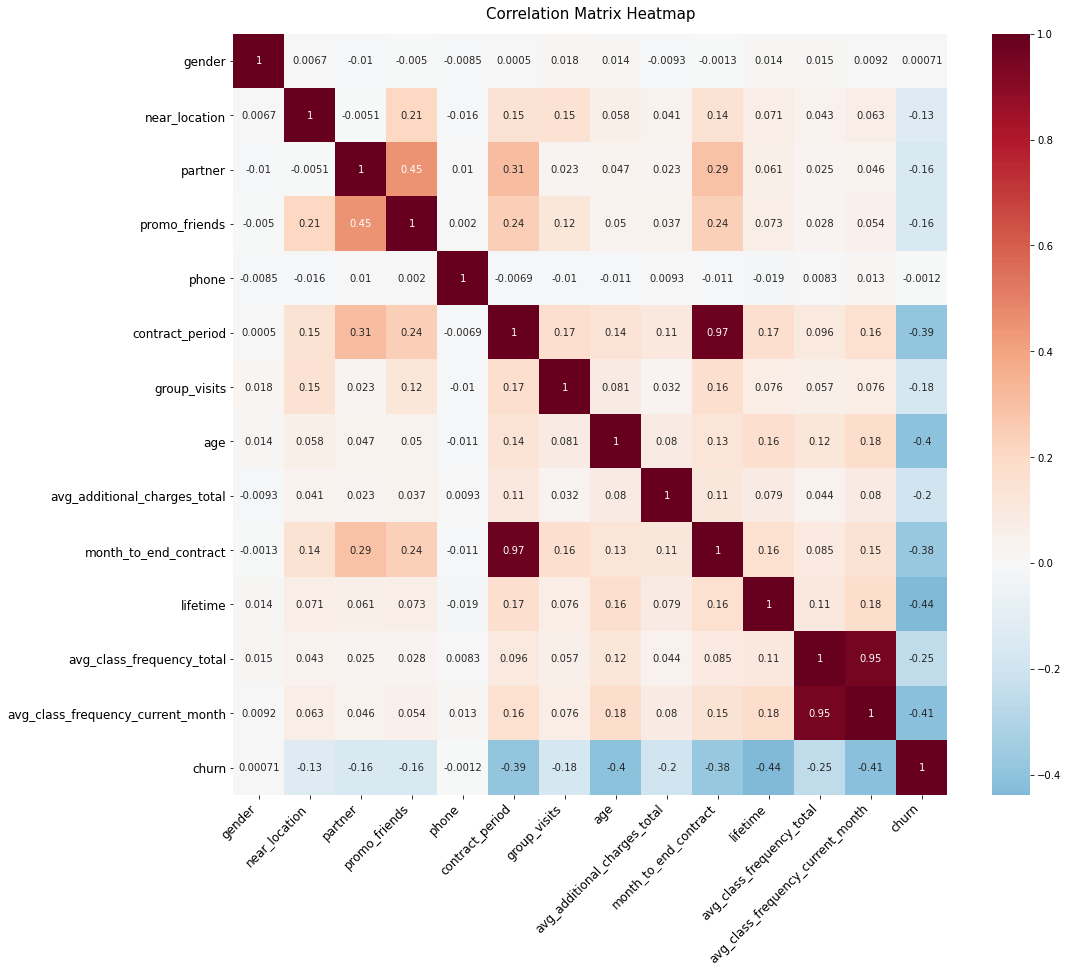

In [10]:
fig,ax = plt.subplots(figsize=(16,14))
sns.heatmap(df.corr(), cmap='RdBu_r', center=0, annot=True)

ax.set_title('Correlation Matrix Heatmap', fontdict={'size':15}, pad=15)
ax.set_yticklabels(df.corr().columns, fontdict={'size':12})
ax.set_xticklabels(df.corr().columns, rotation=45, fontdict={'horizontalalignment': 'right', 'size':12})
plt.show()

As we can see above, some features have very strong correlations. 
 - `month_to_end_contract` correlates with `contract_period`
 - `avg_class_frequency_current_month` unsurprisingly correlates with `avg_class_frequency_total`
 
Also we can say that features the most correlated with churn are: `lifetime`, `avg_class_frequency_current_month`, `age`, `contract_period` and `month_to_end_contract`.
 
Let's visualize the correlation between average class frequency current month vs total through scatterplot for those who left (churn) and those who stayed: 

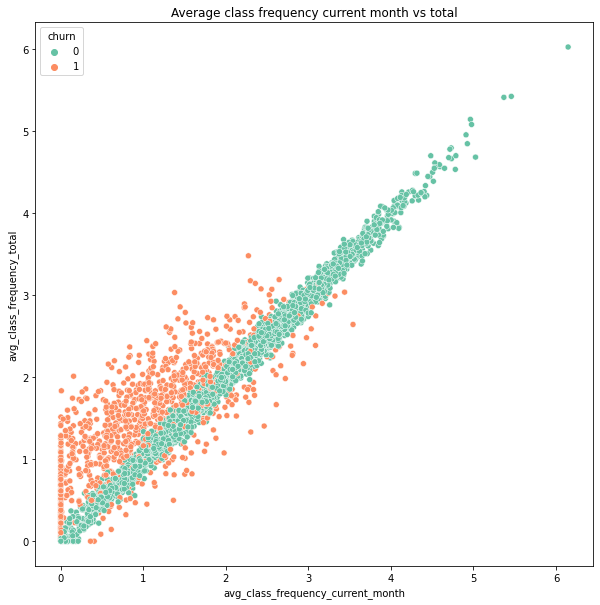

In [11]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,
                x='avg_class_frequency_current_month',
                y='avg_class_frequency_total',
                hue = 'churn', 
                palette='Set2')
plt.title('Average class frequency current month vs total')
plt.show()

That's interesting, we can see from the graph that there's clear linear relation between current month and all previous months for those customers who stayed: average class frequency doesn't vary this month from the usual frequency number. <br>
While for those who left, current month frequency is much less correlated to the previous months and in most cases it's smaller than usual class frequency, basically means that customers attend gym less than usual if they're about to stop using it at all.

Now let's take a look at another correlation: contract period vs months till the end of contract: 

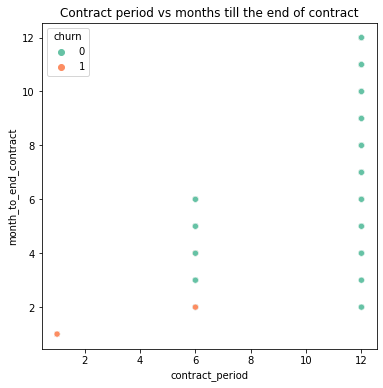

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df,
                x='contract_period',
                y='month_to_end_contract',
                hue = 'churn', 
                palette='Set2')
plt.title('Contract period vs months till the end of contract')
plt.show()

That's quite obvious correlation as well: those users who have longer contracts have longer period till the end of the contract. But from the graph we can see that people churn either at the end of the half-year contract or 1-month contract, but not the whole-year one.

## Step 3. Building a model to predict user churn

We're going to build a binary classification model for customers where the target feature is the user's leaving next month.

First of all, we'll divide the data into train and validation sets with proportion 80% for training and 20% - for validation.
Then we'll train two models based on training dataset: **Logistic Regression** and **Random Forest Classifier**.

We'll evaluate those models' quality by comparing the following metrics for both of them:
 - *Accuracy* - share of accurate predictions among all predictions
 - *Precision* - share of correct answers only in the target class
 - *Recall* - share of relevant instances that were retrieved

In [13]:
# defining the function that will output our metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

# dividing the data into features (the X matrix) and a target variable (y)
X = df.drop('churn', axis = 1)
y = df['churn']
 
# dividing the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# logistic Regression model
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')

print('')

# Random Forest model
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for random forest:')

Metrics for logistic regression:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83

Metrics for random forest:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


Both models performed well, but **Logistic Regression** has higher *Precision* and *Recall*, so it showed better results according to metrics. 

## Step 4. Creating user clusters

Now let's form user clusters. First of all, let's decide with the number that would be optimal using agglomerative hierarchical clustering method and visualize those clusters as a dendrogram:

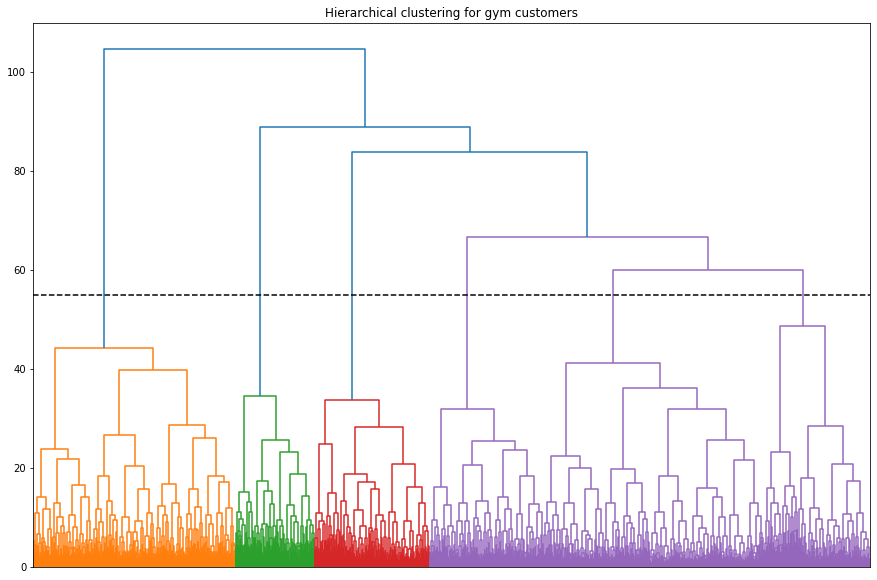

In [16]:
# standardizing the data
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

# building a matrix of distances between all objects
linked = linkage(X_sc, method = 'ward') 

# plotting a dendrogram
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for gym customers')
plt.xticks([])
plt.axhline(y=65, color='black', linestyle='--')
plt.show()

We've got 4 clusters, but one of them is really big, let's divide it into two. <br>
Thus, we now have **5** clusters and as we know their number, we can use K-means algorithm to predict user clusters:

In [67]:
# defining the k_means model with 5 clusters
km = KMeans(n_clusters = 5, random_state = 0)

# predict the clusters for observations (the algorithm assigns them a number from 0 to 4)
labels = km.fit_predict(X_sc)

# storing cluster labels in the field of our dataset
df['cluster_km'] = labels

Let's look at the statistics of the mean feature values per each cluster:

In [69]:
clusters = df.groupby('cluster_km').mean().T
clusters

cluster_km,0,1,2,3,4
gender,0.522078,0.480787,0.559567,0.509603,0.495726
near_location,0.862338,0.812559,0.858002,0.750320,0.943376
partner,0.470130,0.000000,0.338147,1.000000,0.752137
promo_friends,0.306494,0.086223,0.197353,0.451985,0.541667
phone,0.000000,1.000000,0.998797,1.000000,1.000000
contract_period,4.787013,1.866917,2.730445,2.554417,11.352564
group_visits,0.425974,0.325211,0.448857,0.303457,0.564103
age,29.301299,28.145267,30.196149,28.499360,29.993590
avg_additional_charges_total,143.957664,131.369042,164.579011,129.812508,164.563799
month_to_end_contract,4.475325,1.791003,2.519856,2.370038,10.376068


For the ease of detecting deviations let's visualize this table as a heatmap where each cell would be deviation from the mean of the feature among all customers: 

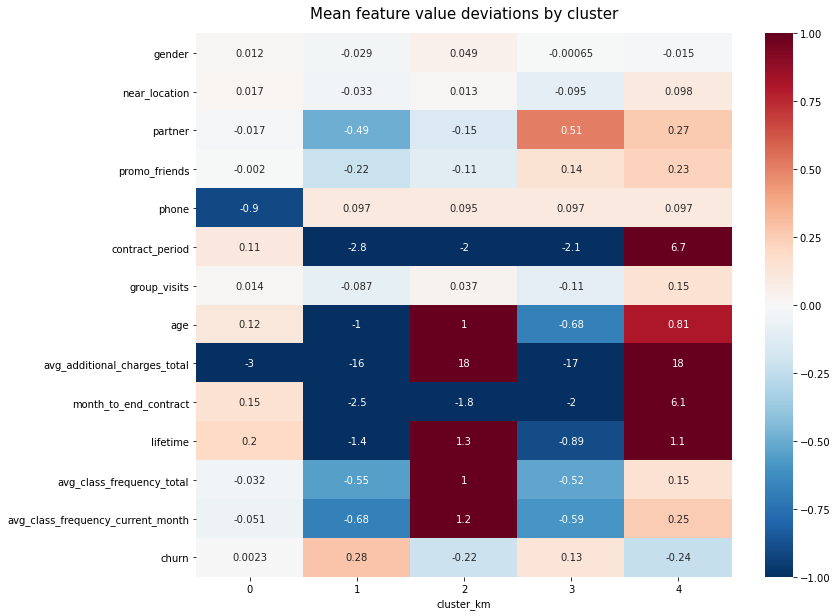

In [19]:
clusters = clusters.sub(df.drop('cluster_km', axis=1).mean().T, axis=0)

fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(clusters, cmap='RdBu_r', vmin=-1, vmax=1, annot=True)
ax.set_title('Mean feature value deviations by cluster', fontdict={'size':15}, pad=15)
plt.show()

From the above heatmap we can say:
 - clusters **2** and **4** are the most loyal
 - cluster **0** is average in terms of churn
 - cluster **3** has higher than average churn and cluster number **1** has the highest
 
Let's see what characterizes each cluster:
#### Cluster 0 (churn 26.7%):
 - no-one of this cluster gives to the gym their **phone number**
 - relatively long **contract period (4.8 months)**
 - **age: 29.3** - slightly higher than average
 - don't tend to spend a lot of money on **additional gym services** 
 - around **4.5 months till the end of contract** - slightly higher than average
 - **lifetime - almost 4 months** - slightly higher than average
 - average **frequency of visits per week** (slightly lower frequency current month than usual)
 
#### Cluster 1 (churn 55%):
 - no-one of this cluster participate in **partner program**
 - also lowest share of users who **signed up through friends**
 - everybody gave their **phone numbers**
 - shortest **contract period**: on average **1.9 months**
 - youngest **age** among other clusters: **28.1**
 - very unlikely to spend a lot of money on **additional gym services** 
 - **1.8 months till the end of contract** - the least among other clusters
 - **lifetime 2.3 months** - the shortest among other clusters
 - lowest **frequency of visits per week** and especially current month (**1** visit per week instead of usual **1.3**)
  
#### Cluster 2 (churn 4.8%):
 - a bit lower than average share of people who participate in **partner program** and **signing up through friends**
 - nearly everybody gave their **phone numbers**
 - quite short **contract period - 2.7 months**
 - oldest **age** among other clusters **30.2** - on average
 - spending a lot of money on **additional gym services**
 - **2.5 months till the end of contract** - less than average
 - the highest **lifetime: 5 months** 
 - highest **frequency of visits per week - 3 times**, and no difference between current and previous months 
   
#### Cluster 3 (churn 39.6%):
 - smallest share of those who **live nearby**
 - all of the customers participate in **partner program**
 - **45% signed up though their friends**, which is higher than average
 - everybody gave their **phone numbers** to the gym
 - average **contract period is 2.6 months** - lower than average
 - average **age is 28.5**, lower than average
 - very unlikely to spend a lot of money on **additional gym services** 
 - **2.4 months till the end of contract** - less than average
 - **lifetime is 2.8 months** - less than average
 - low **frequency of visits per week** and especially current month (**1.1** visit per week instead of usual **1.4**)
    
#### Cluster 4 (churn 2.3%):
 - biggest share of customers who **live nearby**
 - **75%** participate in **partner program**, which is higher than average
 - more than half **signed up though their friends**, which is highest share among other clusters
 - everybody gave their **phone numbers**
 - longest **contract period**: on average **11.4 months** 
 - more than a half attending **group sessions**, which is the highest share among other clusters
 - average **age is 30**, which is higher than average 
 - spending a lot of money on **additional gym services**
 - **10.4 months till the end of contract** - longest period among other clusters
 - **lifetime is 4.8 months**, which is higher than average 
 - very high **frequency of visits per week - 2 times**, and no difference between current and previous months 
 
PS: **Gender** proportions don't vary much between clusters and both genders are represented almost equally.  
 
Now let's plot distributions of features again, but this time for each cluster, so we can visually see the differences between them:

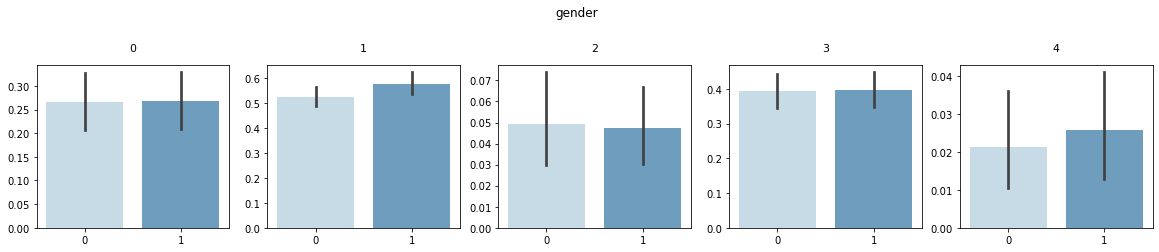

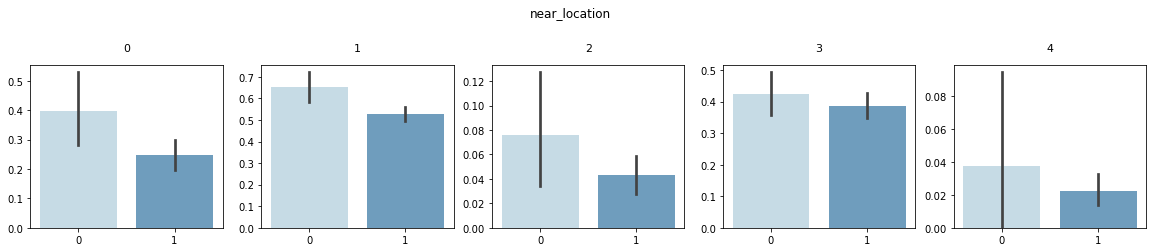

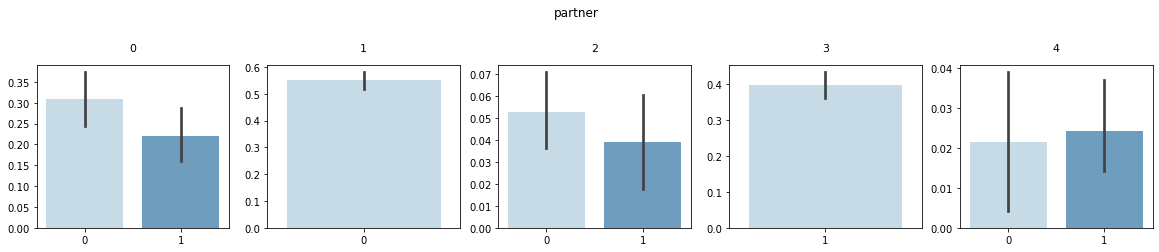

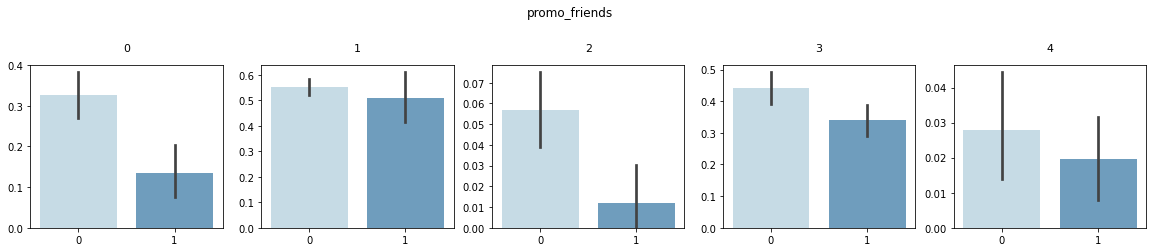

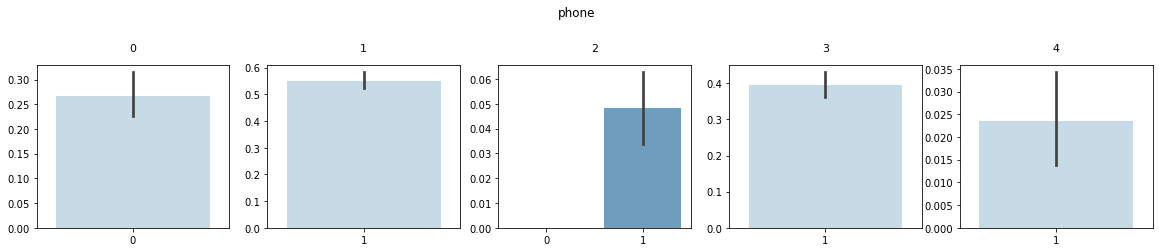

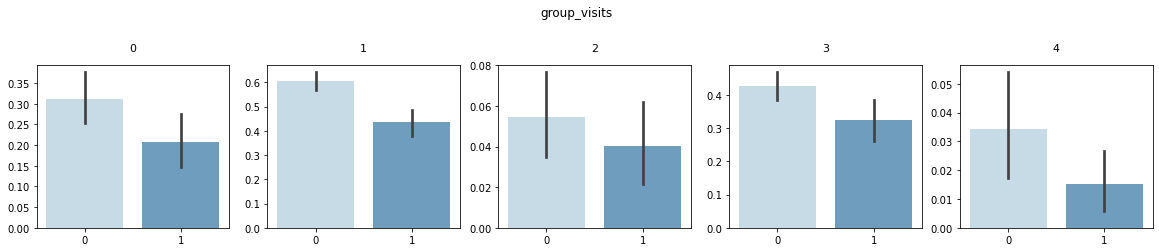

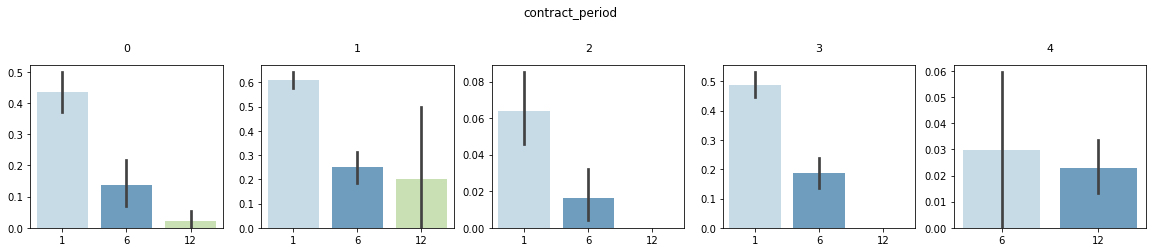

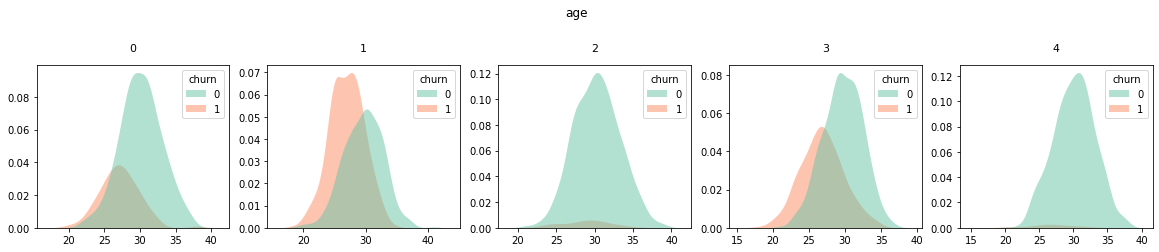

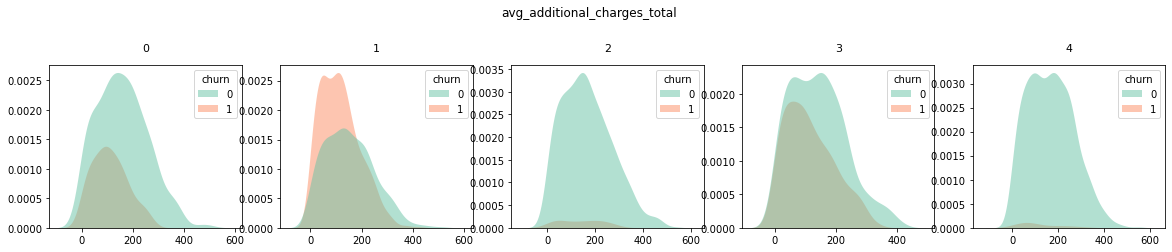

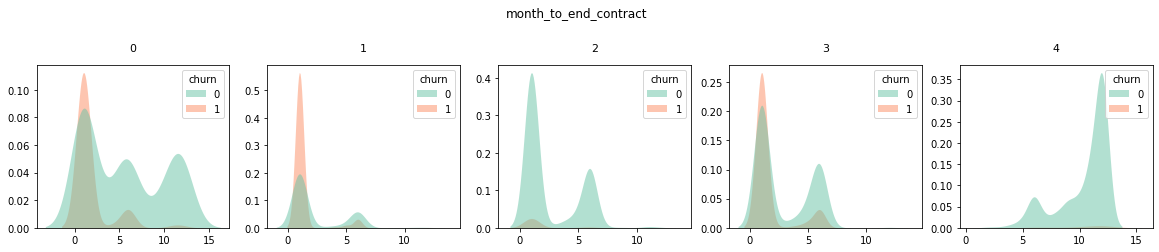

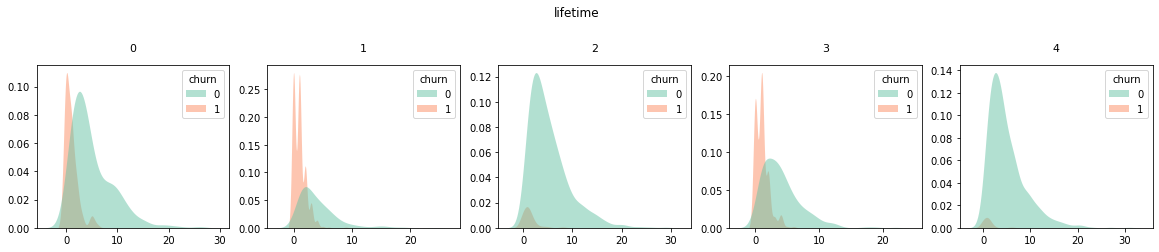

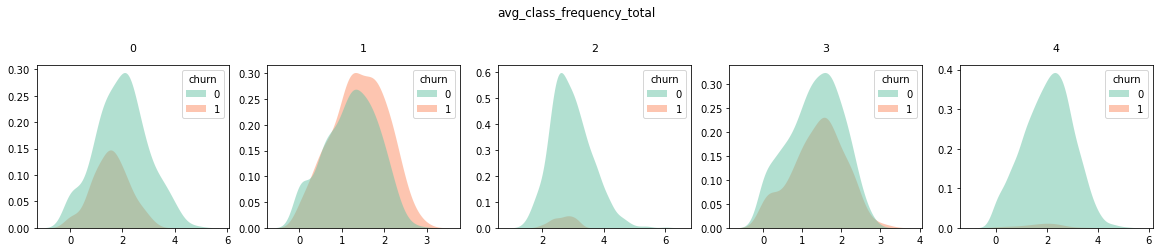

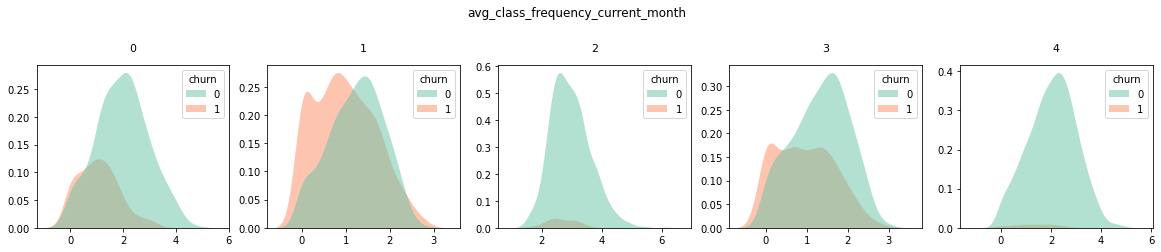

In [66]:
def plot_bar(column):
    fig, axes = plt.subplots(1, 5, figsize=(20, 3))
    for cluster in np.arange(0, 5).tolist():
        sns.barplot(ax=axes[cluster], data=df[df.cluster_km==cluster], x=column,
                    y='churn', fill=True, palette="Paired", alpha=0.7)
        axes[cluster].set_title(cluster, fontdict ={'size':11}, pad=14)
    
    plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='')
    plt.suptitle(column, y=1.15)
    plt.show()
    print('')
    
def plot_distr(column):
    fig, axes = plt.subplots(1, 5, figsize=(20, 3))
    for cluster in np.arange(0, 5).tolist():
        sns.kdeplot(ax=axes[cluster], data=df[df.cluster_km==cluster], x=column,
                    hue='churn', fill=True, palette="Set2", alpha=0.5, linewidth=0)
        axes[cluster].set_title(cluster, fontdict ={'size':11}, pad=14)
      
    plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='')
    plt.suptitle(column, y=1.15)
    plt.show()
    print('')    

for col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 
            'group_visits', 'contract_period']: plot_bar(col)

for col in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                'avg_class_frequency_total', 'avg_class_frequency_current_month']: plot_distr(col)

- As we noticed above, there's almost no difference in **gender** proportions between clusters, however, in cluster 1 and 4 gender 1 tend to churn more and in cluster 2 there's small prevalence of gender 0 in terms of churn
- **close location to the gym** lowers churn for all clusters
- in cluster 1 no-one participates in **partner program**, while in cluster 3 - everyone are taking part in it. for cluster 0 and 2 it lowers churn, but for 4th cluster - rises it
- those who **signed up through friends** tend to churn less - that works for all clusters, especially for 0 and 2
- no-one from 0 cluster gave their **phone number** to the gym, while at all other clusters everyone listed their numbers (cluster 2 - with minor exceptions). Therefore it's hard to tell if presence of customer's phone number affecting churn somehow or not. As we remember, cluster 0 where phone numbers are missing is average in terms of churn
- **group visits** decrease churn for all clusters
- customers with **contract period** for the whole year tend to churn much less, with the exception of cluster 1 where churn for 12-month contract is still relatively high
- customers of younger **age** churn more than the older ones. Exceptions are clusters 2 and 4 which are the most loyal and the churn there is almost unnoticeable. While at clusters 1 and 3 which are much more prone to churn we can clearly see tendency to churn among 20-30 age group
- interesting that in 1 and 3 clusters that are the most unstable, customers who are about to leave are still spending the same amount of money on **additional gym services** as those who are going to stay. In case of 1 cluster, even more money
- those customers who have very few **months till the end of contract** are more likely to leave. Interesting that in each cluster the majority have less than 5 months till the end, but in cluster 4 it's the opposite situation: most of the users have around 12 months till the end. Also at 0 cluster months till the end are distributed more equally
- if customer is going to leave, they are leaving pretty soon after the beginning. Users who tend to churn have minimal **lifetime** in all clusters
- by **average class frequency** we can judge if customer is about to leave as well. If there's a difference in frequency for the current month as opposed to all previous months, that means customer is going to leave the gym. That pattern is quite visible on 1 and 3 - two the most prone to churn clusters.

## Step 5. Overall conclusion

We detected 5 typycal users clusters. Probability of churn for each of them:
- cluster 0: churn **26.7%**
- cluster 1: churn **55%**
- cluster 2: churn **4.8%**
- cluster 3: churn **39.6%**
- cluster 4: churn **2.3%**
 
[Here's detailed description of each cluster](#Cluster-0-(churn-26.7%):)

Factors that impact churn most:
- age
- lifetime
- contract period
- month to end contract
- difference between average weekly activity current month as opposed to previous months

Recommendations on how to cut churn: 
- For clusters 1 and 3: we can try to convince those groups to sign for longer contract periods. Maybe by providing some discount that it would be cheaper price per month if customer signs up for the whole year and not just single month, as for now majority of them signs up for only 1 month. 
- For all clusters, but especially 0, 1 and 3: last month till the end of contract we need to convince the customer to sign up for another contract, again, maybe by providing some discount
- Very important not to lose the customer within the first month or two - that's the time when they usually leave (especially clusters 0, 1 and 3). We somehow need to stimulate them to be more involved and come to the gym more frequently. If customer stayed for more than 5 months, that means he formed the habit to go to the gym and became loyal, most likely, he will stay. 
- Average weekly activity of 1.5 times per week or lower is a bad sign, especially if current month it dropped even further - that's a clear sign that customer is about to leave. We need to try to provide those customers with some motivation to return to the gym. Maybe advertise some group lessons that they may like to join, those people who are attending group sessions are less likely to leave. Or to give some discounts on additional gym services: clusters 1 and 3 that are the most prone to leaving on average spend less money on additional services in the gym.